In [11]:
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

# for CVXPY implementation
from solardatatools.signal_decompositions import tl1_l2d2p365 as cvx_sd
from solardatatools.signal_decompositions_l2norm import tl1_l2d2p365 as cvx_sd_l2norm

# Import data from `tests/fixtures`

In [12]:
# Import data
fixtures_path = "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/"

data_file_path = Path(fixtures_path + "clear_day_detection/one_year_power_signals_1.csv")

with open(data_file_path) as file:
    data = np.loadtxt(file, delimiter=",")
expected_data_file_path = Path(fixtures_path + "clear_day_detection/one_year_weights_1.csv")

with open(expected_data_file_path) as file:
    expected_output = np.loadtxt(file, delimiter=",")

In [13]:
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
tc = np.linalg.norm(data[:-2] - 2 * data[1:-1] + data[2:], ord=1, axis=0)


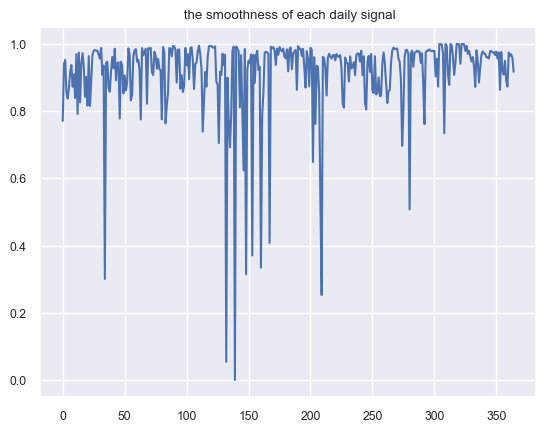

In [4]:
tc = np.linalg.norm(data[:-2] - 2 * data[1:-1] + data[2:], ord=1, axis=0)
# Normalize such that the maximum value is equal to one
tc /= np.nanmax(tc)
tc = 1 - tc

# Calculate the daily energy
de = np.sum(data, axis=0)

plt.plot(tc);
plt.title(" the smoothness of each daily signal");

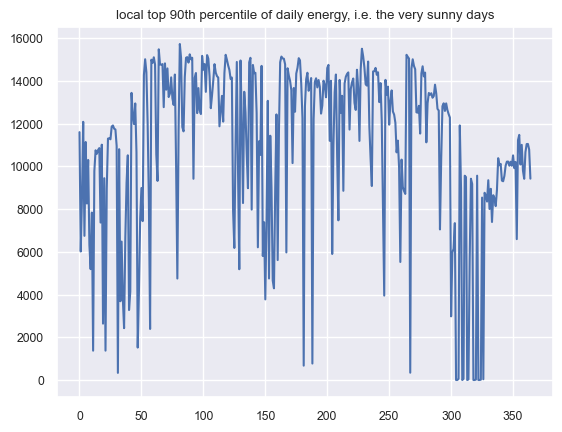

In [5]:
plt.plot(de)
plt.title("local top 90th percentile of daily energy, i.e. the very sunny days");

# Current state: c1=1e3


MAE s_hat  (OSD,CVX)   8.20e-03


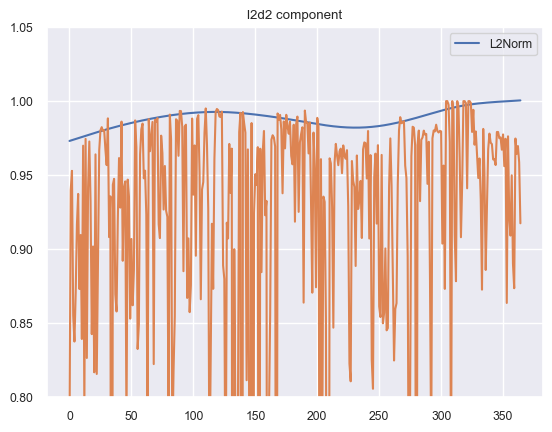

In [9]:
cvx_ss = cvx_sd(tc, tau=0.9, c1=1e3, yearly_periodic=False, solver="MOSEK")
cvx_l2n = cvx_sd_l2norm(tc, tau=0.9, c1=1e3, yearly_periodic=False, solver="MOSEK")

print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_ss, cvx_l2n):.2e}')

f, ax1, = plt.subplots(1, 1, sharex=True)
#ax1.plot(cvx_ss, label="SumSquares")
ax1.plot(cvx_l2n, label="L2Norm")
ax1.plot(tc);
ax1.set_title("l2d2 component")
ax1.set_ylim(0.8,1.05)

ax1.legend()
plt.show()

MAE s_hat  (OSD,CVX)   3.99e+02


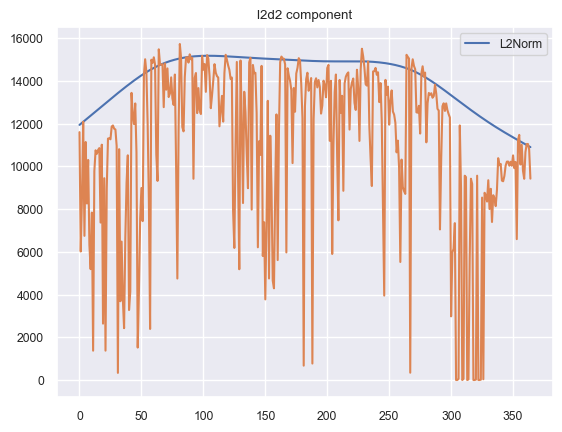

In [10]:
cvx_ss_de = cvx_sd(de, tau=0.9, c1=1e3, yearly_periodic=False, solver="MOSEK")
cvx_l2n_de = cvx_sd_l2norm(de, tau=0.9, c1=1e3, yearly_periodic=False, solver="MOSEK")

print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_ss_de, cvx_l2n_de):.2e}')

f, ax1, = plt.subplots(1, 1, sharex=True)
#ax1.plot(cvx_ss_de, label="SumSquares")
ax1.plot(cvx_l2n_de, label="L2Norm")
ax1.plot(de);
ax1.set_title("l2d2 component")

ax1.legend()
plt.show()

# Optimize c1 for smothness signal

In [78]:
results = {}
weight_iter = np.logspace(6.8, 7, 50)

def run(sig):
    mae_list = []
    for w in tqdm(weight_iter):
        res = cvx_sd(sig, tau=0.9, c1=w, yearly_periodic=False, solver="MOSEK")
        mae_list.append(mae(cvx_l2n, res))
        
    results["weight_min_tc"] =  weight_iter[np.argmin(mae_list)]
    results["mae_min_tc"] = np.min(mae_list)
    results["mae_list_tc"] = mae_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.03it/s]


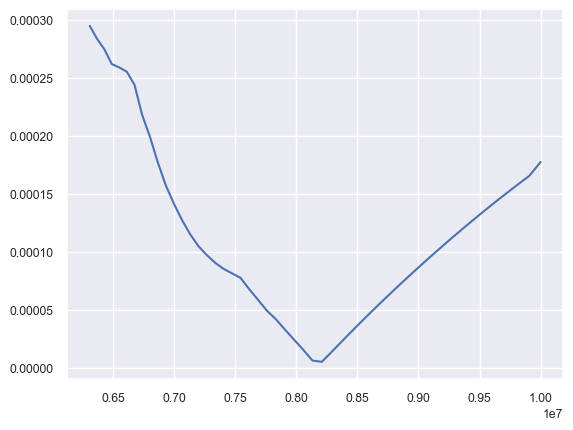

In [79]:
run(tc)
plt.plot(weight_iter, results["mae_list_tc"])

MAE s_hat  (OSD,CVX)   5.26e-06


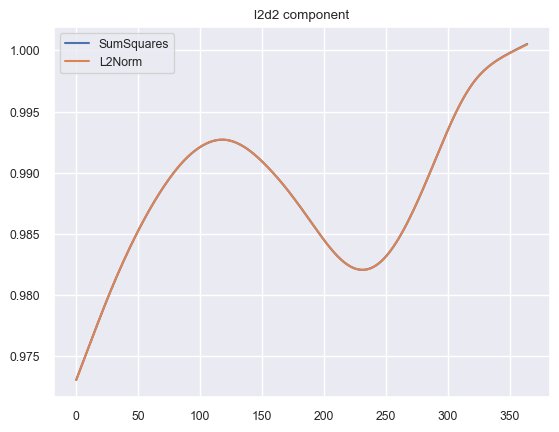

In [80]:
cvx_ss = cvx_sd(tc, tau=0.9, yearly_periodic=False, c1=results["weight_min_tc"], solver="MOSEK")


print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_ss, cvx_l2n):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(cvx_ss, label="SumSquares")
ax1.plot(cvx_l2n, label="L2Norm")
ax1.set_title("l2d2 component")

ax1.legend()
plt.show()

In [82]:
results["weight_min_tc"]

8208914.159638261

# For daily energy signal

In [86]:
weight_iter = np.logspace(1.7, 1.9, 150)

def run(sig):
    mae_list = []
    for w in tqdm(weight_iter):
        res = cvx_sd(sig, tau=0.9, c1=w, yearly_periodic=False, solver="MOSEK")
        mae_list.append(mae(cvx_l2n_de, res))
        
    results["weight_min_de"] =  weight_iter[np.argmin(mae_list)]
    results["mae_min_de"] = np.min(mae_list)
    results["mae_list_de"] = mae_list

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 32.39it/s]


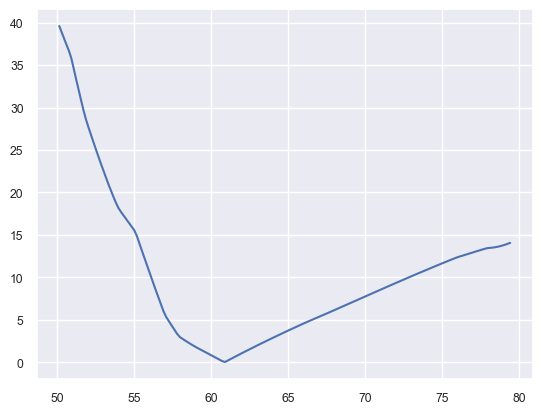

In [87]:
run(de)
plt.plot(weight_iter, results["mae_list_de"])

MAE s_hat  (OSD,CVX)   3.35e-02


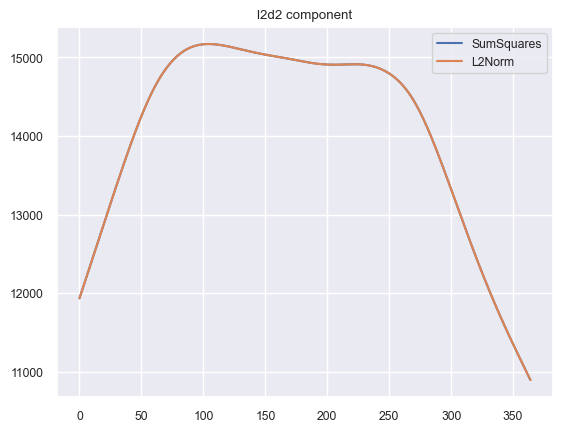

In [88]:
cvx_ss_de = cvx_sd(de, tau=0.9, yearly_periodic=False, c1=results["weight_min_de"], solver="MOSEK")


print(f'MAE s_hat  (OSD,CVX)   {mae(cvx_ss_de, cvx_l2n_de):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(cvx_ss_de, label="SumSquares")
ax1.plot(cvx_l2n_de, label="L2Norm")
ax1.set_title("l2d2 component")

ax1.legend()
plt.show()

In [89]:
results["weight_min_de"]

60.89249349314762